Author: Athénaïs Vaginay (vaginay.athenais@gmail.com)
The latest version of this IPython notebook is available at https://github.com/Athenais/graph-clustering-for-protein-peeling.

In [50]:
# setup the matplotlib graphics library and configure it to show 
# figures inline in the notebook
%matplotlib notebook
import matplotlib.pyplot as plt

In [10]:
pdb_code = "1mbs"
pdb_dir = "test"

In [37]:
from Bio import PDB

pdbl = PDB.PDBList()
pdb_path =  pdbl.retrieve_pdb_file(pdb_code, pdir = pdb_dir)

In [38]:

parser = PDB.PDBParser()

# Parse the structure into a PDB.Structure object
struct = parser.get_structure(pdb_code, pdb_path)


In [ ]:
print struct.header # dict with header infos

In [15]:

points = []

# get Calpha of not hetero res : 
for residue in struct.get_residues():
    tags = residue.get_full_id()
    print tags,
    # tags contains a tuple with (Structure ID, Model ID, Chain ID, (Residue ID))
    # Residue ID is a tuple with (*Hetero Field*, Residue ID, Insertion Code)
    # Thus *Hetero Field*, is empty (tags[3][0] != " ") if the residue is not a hetero atom 
    # or have some flag if it is 
    #   W for waters, 
    #   H for hetero res (e.g. 'H_GLC' in the case of a glucose molecule), 
    #   etc.
    # hetero atoms do not have CA
    try :    
        print residue['CA'].get_coord() 
        points.append(  residue['CA'].get_coord()) 
    except KeyError : 
        print 'Key Error -> can t access CA coord of hetero atom :'  
        print tags[3][0] # flag of the hetero atom


('1MBS', 0, 'A', (' ', 1, ' ')) [ 15.23400021  10.46199989 -10.55599976]
('1MBS', 0, 'A', (' ', 2, ' ')) [ 16.8029995    8.16399956  -7.99399996]
('1MBS', 0, 'A', (' ', 3, ' ')) [ 18.41600037   6.40399981 -10.97200012]
('1MBS', 0, 'A', (' ', 4, ' ')) [ 21.26799965   3.95300007 -11.27600002]
('1MBS', 0, 'A', (' ', 5, ' ')) [ 23.875        6.16599989  -9.59399986]
('1MBS', 0, 'A', (' ', 6, ' ')) [ 21.54500008   7.09000015  -6.7420001 ]
('1MBS', 0, 'A', (' ', 7, ' ')) [ 20.45400047   3.477       -6.29799986]
('1MBS', 0, 'A', (' ', 8, ' ')) [ 24.01399994   2.11899996  -6.28000021]
('1MBS', 0, 'A', (' ', 9, ' ')) [ 25.06699944   4.796       -3.82599998]
('1MBS', 0, 'A', (' ', 10, ' ')) [ 22.21299934   4.03999996  -1.41400003]
('1MBS', 0, 'A', (' ', 11, ' ')) [ 22.74500084   0.294       -1.75699997]
('1MBS', 0, 'A', (' ', 12, ' ')) [ 26.49900055   0.537       -1.09599996]
('1MBS', 0, 'A', (' ', 13, ' ')) [ 26.20400047   2.97799993   1.79900002]
('1MBS', 0, 'A', (' ', 14, ' ')) [ 23.56200027 

<IPython.core.display.Javascript object>


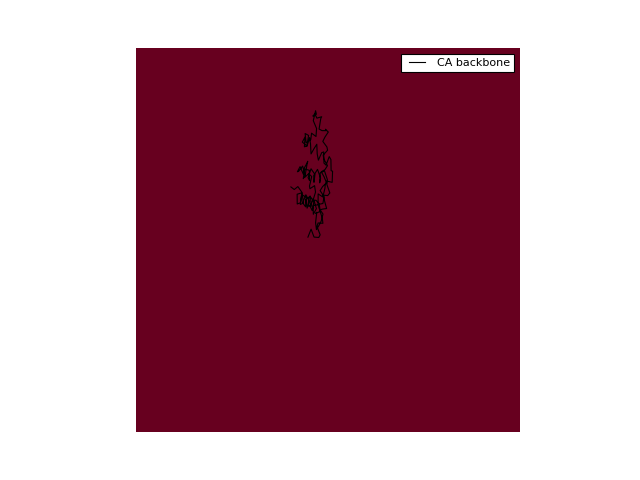

In [55]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')

points = np.array(points)
x = points[:, 0] # or  zip(*points)[0] if no np array
y = points[:, 1]
z = points[:, 2]

ax.plot(x, y, z, label='CA backbone' , color='black' )
ax.scatter(x, y, z,  s=20, c=plt.cm.rainbow(xrange (len (points) )  ))

ax.legend()



plt.show()

In [17]:
import scipy.spatial.distance

dist_condensed = scipy.spatial.distance.pdist(points, 'euclidean') 
# numpy array : values from triangle matrix without diagonal 

print dist_condensed

[ 3.78238117  5.17354289  8.90475313 ...,  3.80814971  5.52240917
  3.80346236]


<IPython.core.display.Javascript object>


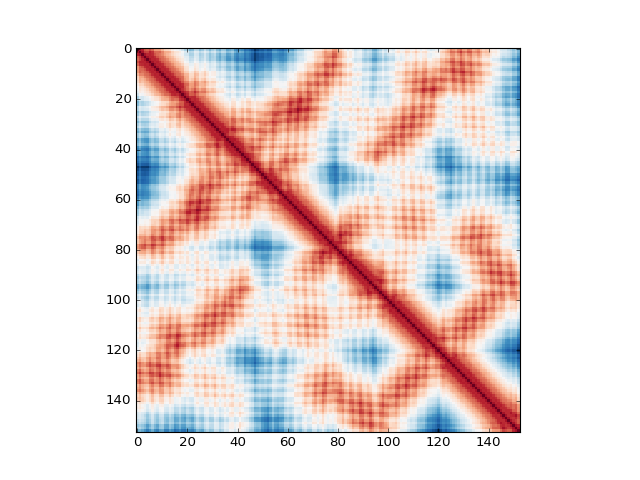

In [54]:
dist = scipy.spatial.distance.squareform(dist_condensed)
plt.imshow(dist, cmap='RdBu', interpolation='None')


plt.show()

In [19]:

d0 = 8  # cutoff fixed to 8 in ref art

# Boolean matrix C in which the element C(i,j) equals 1 if the inter-C a distance d(i,j) 
# between the ith and jth Ca of the protein backbone is less than a cut-off d0.
C_condensed = dist_condensed < d0 

In [63]:
#plot contact matrix : 
C_dec = scipy.spatial.distance.squareform(C_condensed, force='no', checks=False)
np.fill_diagonal(C_dec, 1)

plt.imshow(C_dec, cmap='Greys', interpolation='None')
plt.show()

Use a logistic transformation to have continuous values  instead  of  Boolean  values from the adjacency C matrix : 

In [24]:
d0 = 8
delta  = 1.5   

import numpy as np
P_condensed =   1   / (  1 + np.exp(  (dist_condensed - d0)  / delta ) ) 

In [25]:
assert (  ( P_condensed >= 0).all() and (P_condensed <= 1).all()  )

# Apply MCL algorithm

Use code from http://micans.org/mcl/

In [27]:
P = scipy.spatial.distance.squareform(P_condensed, force='no', checks=False)
np.fill_diagonal(P, 1)


In [29]:
with open('P_'+pdb_code+'.abc', "w") as abc_out : 
	abc_out.write("# P matrix from "+pdb_code+"\n")
	for i, line in enumerate (P) : 
		for j, col in enumerate (line) : 
			abc_out.write( '{0} {1} {2}\n'.format(i, j, P[i, j])  ) 


In [31]:
import subprocess
import shlex 


# convert abc format in mcl suite native format : 
cmd_mcxload = "mcxload -abc {0}.abc --stream-mirror -write-tab {0}.tab -o {0}.mci".format('P_'+pdb_code) 
subprocess.call(shlex.split(cmd_mcxload))
    

0

In [36]:
cmd_mcl_tpl = 'mcl {0}.mci -I %f'.format('P_'+pdb_code)


i_values  = [0.04, 1.4, 2, 3, 4]
for i_value in i_values :
    subprocess.call(shlex.split(cmd_mcl_tpl % i_value))